In [1]:
# === 1. Imports ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings("ignore")

# === 2. Load and Clean Data ===
df = pd.read_excel("Maxico.xlsx")
df = df[['Year', 'Land_used(ha)']].copy()

# Clean 'Land_used(ha)' column: remove commas, NBSPs, etc.
df['Land_used(ha)'] = (
    df['Land_used(ha)']
    .astype(str)
    .str.replace(',', '')
    .str.replace('\xa0', '')
    .astype(float)
)

# Sort and reset index
df = df.sort_values('Year').reset_index(drop=True)

# === 3. Create Lag Features ===
def create_lag_features(series, window=3):
    X, y = [], []
    for i in range(window, len(series)):
        X.append(series[i-window:i])
        y.append(series[i])
    return np.array(X), np.array(y)

land_used = df['Land_used(ha)'].values
years = df['Year'].tolist()

# Up to 2010 (index 3: 2008-2010), start predicting from 2011
X_train, y_train = create_lag_features(land_used[:13], window=3)  # 2008–2010 to predict 2011–2021

# === 4. Train Traditional Models ===
rf = RandomForestRegressor(n_estimators=100, random_state=42)
xgb = XGBRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
xgb.fit(X_train, y_train)

# === 5. Train LSTM & GRU ===
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_train)
y_scaled = scaler.fit_transform(y_train.reshape(-1, 1))

# LSTM
model_lstm = Sequential([
    LSTM(50, activation='relu', input_shape=(3,1)),
    Dense(1)
])
model_lstm.compile(optimizer='adam', loss='mse')
model_lstm.fit(X_scaled.reshape(-1, 3, 1), y_scaled, epochs=100, verbose=0)

# GRU
model_gru = Sequential([
    GRU(50, activation='relu', input_shape=(3,1)),
    Dense(1)
])
model_gru.compile(optimizer='adam', loss='mse')
model_gru.fit(X_scaled.reshape(-1, 3, 1), y_scaled, epochs=100, verbose=0)

# === 6. Recursive Prediction from 2011 to 2022 ===
series = list(land_used[:3])  # 2008–2010
actual = land_used[3:]       # 2011–2022
pred_years = years[3:]

rf_preds, xgb_preds, arima_preds, lstm_preds, gru_preds = [], [], [], [], []

for i in range(len(actual)):
    input_seq = np.array(series[-3:]).reshape(1, -1)
    
    # Random Forest & XGBoost
    rf_pred = rf.predict(input_seq)[0]
    xgb_pred = xgb.predict(input_seq)[0]
    
    # ARIMA
    model_arima = ARIMA(series, order=(2, 1, 0))
    model_fit = model_arima.fit()
    arima_pred = model_fit.forecast()[0]
    
    # LSTM & GRU
    input_seq = np.array(series[-3:]).reshape(-1, 1)  # shape: (3, 1)
    input_scaled = scaler.transform(input_seq).reshape((1, 3, 1))  # shape: (1, 3, 1)
    lstm_pred = scaler.inverse_transform(model_lstm.predict(input_scaled, verbose=0))[0][0]
    gru_pred = scaler.inverse_transform(model_gru.predict(input_scaled, verbose=0))[0][0]
    
    # Save predictions
    rf_preds.append(rf_pred)
    xgb_preds.append(xgb_pred)
    arima_preds.append(arima_pred)
    lstm_preds.append(lstm_pred)
    gru_preds.append(gru_pred)
    
    # Update sequence for next iteration
    series.append(rf_pred)  # You can use ensemble instead here if you want

# === 7. Ensemble (average) ===
ensemble_preds = (
    np.array(rf_preds) +
    np.array(xgb_preds) +
    np.array(arima_preds) +
    np.array(lstm_preds) +
    np.array(gru_preds)
) / 5

# === 8. Evaluation Function ===
def evaluate(y_true, y_pred):
    return {
        "R2": r2_score(y_true, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
        "MAE": mean_absolute_error(y_true, y_pred)
    }

# === 9. Evaluation Table ===
results = {
    "ARIMA": evaluate(actual, arima_preds),
    "Random Forest": evaluate(actual, rf_preds),
    "XGBoost": evaluate(actual, xgb_preds),
    "LSTM": evaluate(actual, lstm_preds),
    "GRU": evaluate(actual, gru_preds),
    "Ensemble": evaluate(actual, ensemble_preds)
}
results_df = pd.DataFrame(results).T
print("\n Model Evaluation Table:\n", results_df)

# === 10. Year-wise Prediction Table ===
pred_table = pd.DataFrame({
    "Year": pred_years,
    "Actual": actual,
    "ARIMA": arima_preds,
    "Random Forest": rf_preds,
    "XGBoost": xgb_preds,
    "LSTM": lstm_preds,
    "GRU": gru_preds,
    "Ensemble": ensemble_preds
})
desired_order = ["Year", "Actual", "ARIMA", "Random Forest", "XGBoost", "LSTM", "GRU", "Ensemble"]
pred_table = pred_table[desired_order]

print("\n Year-wise Prediction Table:\n", pred_table.to_string(index=False))




 Model Evaluation Table:
                      R2          RMSE           MAE
ARIMA          0.676892  15328.983524  12799.867842
Random Forest  0.628547  16435.818564  13848.440000
XGBoost        0.676820  15330.690198   9255.354167
LSTM           0.609782  16845.850060  12953.197917
GRU            0.621800  16584.409369  13362.541667
Ensemble       0.702211  14716.126080  11933.018293

 Year-wise Prediction Table:
  Year   Actual         ARIMA  Random Forest     XGBoost        LSTM         GRU      Ensemble
 2011 713824.0 703556.187721      737127.83 713824.1875 726233.1250 727916.6250 721731.591044
 2012 735127.0 738101.307609      754073.52 735127.0625 736928.1875 739751.0000 740796.215522
 2013 782801.0 754073.537463      770579.62 782800.8125 746330.6250 750889.4375 760934.806493
 2014 761834.0 770922.690508      772253.19 766002.9375 760960.9375 763738.2500 766775.601102
 2015 758608.0 772167.335389      781727.24 766002.9375 768369.1250 770119.0625 771677.140078
 2016 781054.0

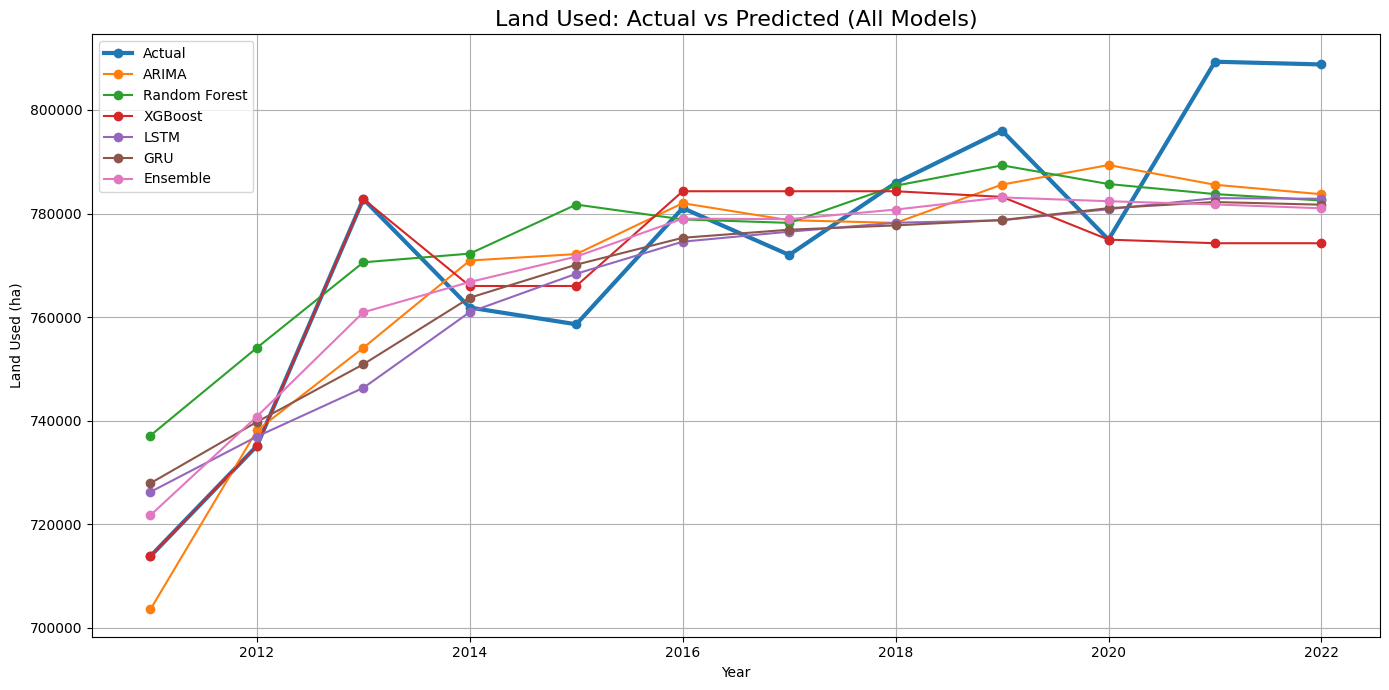

In [2]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
plt.plot(pred_table["Year"], pred_table["Actual"], label="Actual", marker='o', linewidth=3)
plt.plot(pred_table["Year"], pred_table["ARIMA"], label="ARIMA", marker='o')
plt.plot(pred_table["Year"], pred_table["Random Forest"], label="Random Forest", marker='o')
plt.plot(pred_table["Year"], pred_table["XGBoost"], label="XGBoost", marker='o')
plt.plot(pred_table["Year"], pred_table["LSTM"], label="LSTM", marker='o')
plt.plot(pred_table["Year"], pred_table["GRU"], label="GRU", marker='o')
plt.plot(pred_table["Year"], pred_table["Ensemble"], label="Ensemble", marker='o')

plt.title("Land Used: Actual vs Predicted (All Models)", fontsize=16)
plt.xlabel("Year")
plt.ylabel("Land Used (ha)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [1]:
#Stacked Ensemble

# === 1. Imports ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU
import warnings
warnings.filterwarnings("ignore")

# === 2. Load and Clean Data ===
df = pd.read_excel("Maxico.xlsx")
df = df[['Year', 'Land_used(ha)']].copy()
df['Land_used(ha)'] = (
    df['Land_used(ha)']
    .astype(str)
    .str.replace(',', '')
    .str.replace('\xa0', '')
    .astype(float)
)
df = df.sort_values('Year').reset_index(drop=True)

# === 3. Create Lag Features ===
def create_lag_features(series, window=3):
    X, y = [], []
    for i in range(window, len(series)):
        X.append(series[i-window:i])
        y.append(series[i])
    return np.array(X), np.array(y)

land_used = df['Land_used(ha)'].values
years = df['Year'].tolist()
X_train, y_train = create_lag_features(land_used[:13], window=3)  # 2008–2010 → predict 2011–2021

# === 4. Train Base Models ===
rf = RandomForestRegressor(n_estimators=100, random_state=42)
xgb = XGBRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
xgb.fit(X_train, y_train)

# === 5. Train LSTM & GRU ===
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_train)
y_scaled = scaler.fit_transform(y_train.reshape(-1, 1))

# LSTM
model_lstm = Sequential([
    LSTM(50, activation='relu', input_shape=(3,1)),
    Dense(1)
])
model_lstm.compile(optimizer='adam', loss='mse')
model_lstm.fit(X_scaled.reshape(-1, 3, 1), y_scaled, epochs=100, verbose=0)

# GRU
model_gru = Sequential([
    GRU(50, activation='relu', input_shape=(3,1)),
    Dense(1)
])
model_gru.compile(optimizer='adam', loss='mse')
model_gru.fit(X_scaled.reshape(-1, 3, 1), y_scaled, epochs=100, verbose=0)

# === 6. Recursive Base Predictions for 2011–2022 ===
series = list(land_used[:3])  # Start from 2008–2010
actual = land_used[3:]       # Ground truth: 2011–2022
pred_years = years[3:]

rf_preds, xgb_preds, arima_preds, lstm_preds, gru_preds = [], [], [], [], []
stacked_features = []

for i in range(len(actual)):
    input_seq = np.array(series[-3:]).reshape(1, -1)

    # Random Forest & XGBoost
    rf_pred = rf.predict(input_seq)[0]
    xgb_pred = xgb.predict(input_seq)[0]

    # ARIMA
    model_arima = ARIMA(series, order=(2, 1, 0))
    model_fit = model_arima.fit()
    arima_pred = model_fit.forecast()[0]

    # LSTM & GRU
    input_seq_scaled = scaler.transform(np.array(series[-3:]).reshape(-1, 1)).reshape((1, 3, 1))
    lstm_pred = scaler.inverse_transform(model_lstm.predict(input_seq_scaled, verbose=0))[0][0]
    gru_pred = scaler.inverse_transform(model_gru.predict(input_seq_scaled, verbose=0))[0][0]

    # Save base model predictions
    rf_preds.append(rf_pred)
    xgb_preds.append(xgb_pred)
    arima_preds.append(arima_pred)
    lstm_preds.append(lstm_pred)
    gru_preds.append(gru_pred)

    # Collect features for stacking
    stacked_features.append([arima_pred, rf_pred, xgb_pred, lstm_pred, gru_pred])

    # Update sequence for next iteration (using rf_pred arbitrarily)
    series.append(rf_pred)

# === 7. Stacking: Train Meta Model ===
meta_X = np.array(stacked_features)
meta_y = np.array(actual)
meta_model = LinearRegression()
meta_model.fit(meta_X, meta_y)
stacked_preds = meta_model.predict(meta_X)

# === 8. Evaluation Function ===
def evaluate(y_true, y_pred):
    return {
        "R2": r2_score(y_true, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
        "MAE": mean_absolute_error(y_true, y_pred)
    }

# === 9. Evaluation Table ===
results = {
    "ARIMA": evaluate(actual, arima_preds),
    "Random Forest": evaluate(actual, rf_preds),
    "XGBoost": evaluate(actual, xgb_preds),
    "LSTM": evaluate(actual, lstm_preds),
    "GRU": evaluate(actual, gru_preds),
    "Stacked Ensemble": evaluate(actual, stacked_preds)
}
results_df = pd.DataFrame(results).T
print("\nModel Evaluation Table:\n", results_df)

# === 10. Year-wise Prediction Table ===
pred_table = pd.DataFrame({
    "Year": pred_years,
    "Actual": actual,
    "ARIMA": arima_preds,
    "Random Forest": rf_preds,
    "XGBoost": xgb_preds,
    "LSTM": lstm_preds,
    "GRU": gru_preds,
    "Stacked Ensemble": stacked_preds
})
print("\nYear-wise Prediction Table:\n", pred_table.to_string(index=False))



Model Evaluation Table:
                         R2          RMSE           MAE
ARIMA             0.676892  15328.983524  12799.867842
Random Forest     0.628547  16435.818564  13848.440000
XGBoost           0.676820  15330.690198   9255.354167
LSTM              0.610184  16837.161956  12880.567708
GRU               0.635176  16288.483117  13298.364583
Stacked Ensemble  0.835261  10945.536302   9235.431741

Year-wise Prediction Table:
  Year   Actual         ARIMA  Random Forest     XGBoost        LSTM         GRU  Stacked Ensemble
 2011 713824.0 703556.187721      737127.83 713824.1875 725777.8125 726388.6875     714229.911967
 2012 735127.0 738101.307609      754073.52 735127.0625 736195.1875 739214.9375     740936.886974
 2013 782801.0 754073.537463      770579.62 782800.8125 745392.9375 751806.1250     771657.428730
 2014 761834.0 770922.690508      772253.19 766002.9375 760175.8125 766123.0000     754515.450211
 2015 758608.0 772167.335389      781727.24 766002.9375 767839.0625 7

In [2]:
# === 1. Imports ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU
import warnings
warnings.filterwarnings("ignore")

# === 2. Load and Clean Data ===
df = pd.read_excel("Mexico_full.xlsx")
df = df[['Year', 'Land_used(ha)']].copy()
df['Land_used(ha)'] = df['Land_used(ha)'].astype(str).str.replace(',', '').str.replace('\xa0', '').astype(float)
df = df.sort_values('Year').reset_index(drop=True)

# === 3. Handle Outliers Using IQR Clipping ===
Q1 = df['Land_used(ha)'].quantile(0.25)
Q3 = df['Land_used(ha)'].quantile(0.75)
IQR = Q3 - Q1
df['Land_used(ha)'] = np.clip(df['Land_used(ha)'], Q1 - 1.5 * IQR, Q3 + 1.5 * IQR)

# === 4. Create Lag Features ===
def create_lag_features(series, window=3):
    X, y = [], []
    for i in range(window, len(series)):
        X.append(series[i-window:i])
        y.append(series[i])
    return np.array(X), np.array(y)



land_used = df['Land_used(ha)'].values
years = df['Year'].tolist()
train_start = years.index(2005)  # Need 3 years before first prediction
train_end = years.index(2023) + 1  # inclusive end index
start_idx = years.index(2005)
X_train, y_train = create_lag_features(land_used[train_start:train_end], window=3)
pred_years = years[train_start + 3:train_end]  # 2008 to 2023
actual = land_used[train_start + 3:train_end]



# === 5. Hyperparameter Tuning ===
def tune_model(model, param_grid):
    grid = GridSearchCV(model, param_grid, cv=3)
    grid.fit(X_train, y_train)
    return grid.best_estimator_

models = {}

models['Random Forest'] = tune_model(RandomForestRegressor(random_state=42), {
    'n_estimators': [100, 200], 'max_depth': [None, 5, 10]
})

models['XGBoost'] = tune_model(XGBRegressor(random_state=42, verbosity=0), {
    'n_estimators': [100, 200], 'learning_rate': [0.05, 0.1], 'max_depth': [3, 5]
})

models['Decision Tree'] = tune_model(DecisionTreeRegressor(random_state=42), {
    'max_depth': [3, 5, 10]
})

models['SVM'] = tune_model(SVR(), {
    'C': [0.1, 1, 10], 'kernel': ['rbf', 'linear']
})

models['Gradient Boost'] = tune_model(GradientBoostingRegressor(random_state=42), {
    'n_estimators': [100, 200], 'learning_rate': [0.05, 0.1], 'max_depth': [3, 5]
})

# === 6. Train LSTM & GRU ===
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_train)
y_scaled = scaler.fit_transform(y_train.reshape(-1, 1))

model_lstm = Sequential([LSTM(50, activation='relu', input_shape=(3,1)), Dense(1)])
model_lstm.compile(optimizer='adam', loss='mse')
model_lstm.fit(X_scaled.reshape(-1, 3, 1), y_scaled, epochs=100, verbose=0)

model_gru = Sequential([GRU(50, activation='relu', input_shape=(3,1)), Dense(1)])
model_gru.compile(optimizer='adam', loss='mse')
model_gru.fit(X_scaled.reshape(-1, 3, 1), y_scaled, epochs=100, verbose=0)

# === 7. Recursive Forecast ===
series = list(land_used[start_idx-3:start_idx])
preds = {name: [] for name in models}
arima_preds, lstm_preds, gru_preds = [], [], []
stacked_features = []

for _ in range(16):  # Predict 2008 to 2022
    input_seq = np.array(series[-3:]).reshape(1, -1)

    pred_row = []

    # Classical ML Models
    for name, model in models.items():
        pred = model.predict(input_seq)[0]
        preds[name].append(pred)
        pred_row.append(pred)

    # ARIMA
    model_arima = ARIMA(series, order=(2, 1, 0))
    arima_pred = model_arima.fit().forecast()[0]
    arima_preds.append(arima_pred)
    pred_row.append(arima_pred)

    # LSTM & GRU
    input_seq_scaled = scaler.transform(np.array(series[-3:]).reshape(-1, 1)).reshape((1, 3, 1))
    lstm_pred = scaler.inverse_transform(model_lstm.predict(input_seq_scaled, verbose=0))[0][0]
    gru_pred = scaler.inverse_transform(model_gru.predict(input_seq_scaled, verbose=0))[0][0]
    lstm_preds.append(lstm_pred)
    gru_preds.append(gru_pred)
    pred_row.extend([lstm_pred, gru_pred])

    stacked_features.append(pred_row)
    series.append(pred_row[0])  # arbitrary update, could be mean(pred_row)

# === 8. Stacking Ensemble ===
meta_X = np.array(stacked_features)
meta_y = np.array(actual)
meta_model = LinearRegression()
meta_model.fit(meta_X, meta_y)
stacked_preds = meta_model.predict(meta_X)

# === 9. Evaluation Function ===
def evaluate(y_true, y_pred):
    return {
        "R2": r2_score(y_true, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
        "MAE": mean_absolute_error(y_true, y_pred)
    }

# === 10. Evaluation Table ===
results = {
    "ARIMA": evaluate(actual, arima_preds),
    "LSTM": evaluate(actual, lstm_preds),
    "GRU": evaluate(actual, gru_preds),
    "Stacked Ensemble": evaluate(actual, stacked_preds)
}
for name in preds:
    results[name] = evaluate(actual, preds[name])

results_df = pd.DataFrame(results).T
print("\n📊 Model Evaluation Table:\n", results_df)

# === 11. Year-wise Table ===
pred_table = pd.DataFrame({
    "Year": pred_years,
    "Actual": actual,
    "ARIMA": arima_preds,
    "LSTM": lstm_preds,
    "GRU": gru_preds,
    "Stacked Ensemble": stacked_preds
})
for name in preds:
    pred_table[name] = preds[name]

print("\n📅 Year-wise Prediction Table:\n", pred_table.to_string(index=False))



📊 Model Evaluation Table:
                         R2          RMSE           MAE
ARIMA             0.708008  20522.645889  16087.973719
LSTM              0.810634  16527.174062  12533.976562
GRU               0.816443  16271.717594  12117.597656
Stacked Ensemble  0.969600   6621.971998   5634.569461
Random Forest     0.937557   9490.553641   8111.330000
XGBoost           0.918980  10810.464137   7712.910156
Decision Tree     0.936153   9596.586731   7589.062500
SVM               0.425861  28777.739749  20784.901077
Gradient Boost    0.944203   8971.276773   6894.534486

📅 Year-wise Prediction Table:
  Year   Actual         ARIMA        LSTM         GRU  Stacked Ensemble  Random Forest     XGBoost  Decision Tree           SVM  Gradient Boost
 2008 691441.0 652245.147437 686083.3125 690081.9375     698684.265144      699479.31 692082.0000  691441.000000 637542.477623   691498.783638
 2009 710585.0 700524.682032 696914.0625 702559.5625     699326.811163      701743.82 692082.0000  69144

In [ ]:
# === Stage 3: Predict Sugar_Prod(tons) from Land_used and Sugarcane_Yield ===

# === 1. Imports ===
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# === 2. Load and Clean ===
df = pd.read_excel("Mexico_full.xlsx")
df = df[['Year', 'Land_used(ha)', 'Sugarcane_Yield(t/ha)', 'Sugar_Prod(tons)']].copy()
df = df.apply(lambda col: col.astype(str).str.replace(',', '').str.replace('\xa0', '') if col.name != 'Year' else col)
df[['Land_used(ha)', 'Sugarcane_Yield(t/ha)', 'Sugar_Prod(tons)']] = df[['Land_used(ha)', 'Sugarcane_Yield(t/ha)', 'Sugar_Prod(tons)']].astype(float)
df = df.sort_values('Year').reset_index(drop=True)

# === 3. Feature and Target Creation ===
X = df[['Land_used(ha)', 'Sugarcane_Yield(t/ha)']].values
y = df['Sugar_Prod(tons)'].values
y_log = np.log1p(y)  # Log-transform to stabilize variance

# === 4. Train-Test Split ===
X_train, X_test, y_train_log, y_test_log = train_test_split(X, y_log, test_size=0.2, shuffle=False)

# === 5. Standardization ===
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

y_train_scaled = scaler_y.fit_transform(y_train_log.reshape(-1, 1)).ravel()
y_test_scaled = scaler_y.transform(y_test_log.reshape(-1, 1)).ravel()

# === 6. Model Tuning Function ===
def tune_model(model, param_grid):
    grid = GridSearchCV(model, param_grid, cv=3)
    grid.fit(X_train_scaled, y_train_scaled)
    return grid.best_estimator_

# === 7. Train Models (without MLP) ===
models = {
    'Random Forest': tune_model(RandomForestRegressor(random_state=0), {
        'n_estimators': [100], 'max_depth': [5, 10, None]
    }),
    'Gradient Boost': tune_model(GradientBoostingRegressor(random_state=0), {
        'n_estimators': [100], 'learning_rate': [0.05, 0.1], 'max_depth': [3, 5]
    }),
    'SVR': tune_model(SVR(), {'C': [1, 10], 'kernel': ['rbf']}),
    'Ridge': tune_model(Ridge(), {'alpha': [0.1, 1.0, 10]})
}

# === 8. LSTM & GRU ===
X_seq_train = X_train_scaled.reshape(-1, 2, 1)
X_seq_test = X_test_scaled.reshape(-1, 2, 1)

model_lstm = Sequential([LSTM(50, activation='relu', input_shape=(2, 1)), Dense(1)])
model_lstm.compile(optimizer='adam', loss='mse')
model_lstm.fit(X_seq_train, y_train_scaled, epochs=100, verbose=0)

model_gru = Sequential([GRU(50, activation='relu', input_shape=(2, 1)), Dense(1)])
model_gru.compile(optimizer='adam', loss='mse')
model_gru.fit(X_seq_train, y_train_scaled, epochs=100, verbose=0)

# === 9. Predictions ===
preds = {}

for name, model in models.items():
    pred_scaled = model.predict(X_test_scaled)
    pred_log = scaler_y.inverse_transform(pred_scaled.reshape(-1, 1)).ravel()
    preds[name] = np.expm1(pred_log)

lstm_scaled = model_lstm.predict(X_seq_test, verbose=0).ravel()
gru_scaled = model_gru.predict(X_seq_test, verbose=0).ravel()

preds['LSTM'] = np.expm1(scaler_y.inverse_transform(lstm_scaled.reshape(-1, 1)).ravel())
preds['GRU'] = np.expm1(scaler_y.inverse_transform(gru_scaled.reshape(-1, 1)).ravel())

# === 10. Stacked Ensemble ===
meta_X = np.column_stack(list(preds.values()))
meta_model = LinearRegression()
meta_model.fit(meta_X, np.expm1(y_test_log))
stacked_preds = meta_model.predict(meta_X)
preds['Stacked Ensemble'] = stacked_preds

# === 11. Evaluation ===
def evaluate(y_true, y_pred):
    return {
        'R2': r2_score(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'MAE': mean_absolute_error(y_true, y_pred)
    }

actual = np.expm1(y_test_log)
results_df = pd.DataFrame({name: evaluate(actual, pred) for name, pred in preds.items()}).T
print("\n📊 Stage 3 Evaluation without MLP:\n", results_df)

# === 12. Visualization ===
plt.figure(figsize=(14, 6))
plt.plot(range(len(actual)), actual, label="Actual", marker='o')
for name, pred in preds.items():
    plt.plot(range(len(actual)), pred, label=name, linestyle='--', marker='x')
plt.title("Stage 3: Sugar Production Prediction")
plt.xlabel("Test Samples")
plt.ylabel("Sugar_Prod (tons)")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for i, metric in enumerate(['R2', 'RMSE', 'MAE']):
    sns.barplot(x=results_df.index, y=results_df[metric], ax=axes[i], palette='plasma')
    axes[i].set_title(metric)
    axes[i].tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()



📊 Stage 4 Evaluation (2008-2022 data):
                          R2          RMSE           MAE
Random Forest     -0.053507  2.510273e+05  1.805739e+05
Gradient Boost    -1.173453  3.605599e+05  3.009916e+05
SVR               -1.371273  3.766110e+05  3.123106e+05
Ridge              0.163422  2.236946e+05  1.778594e+05
LSTM             -14.550874  9.644498e+05  7.899130e+05
GRU              -37.231515  1.512213e+06  1.459315e+06
Stacked Ensemble   0.998935  7.983173e+03  6.296570e+03


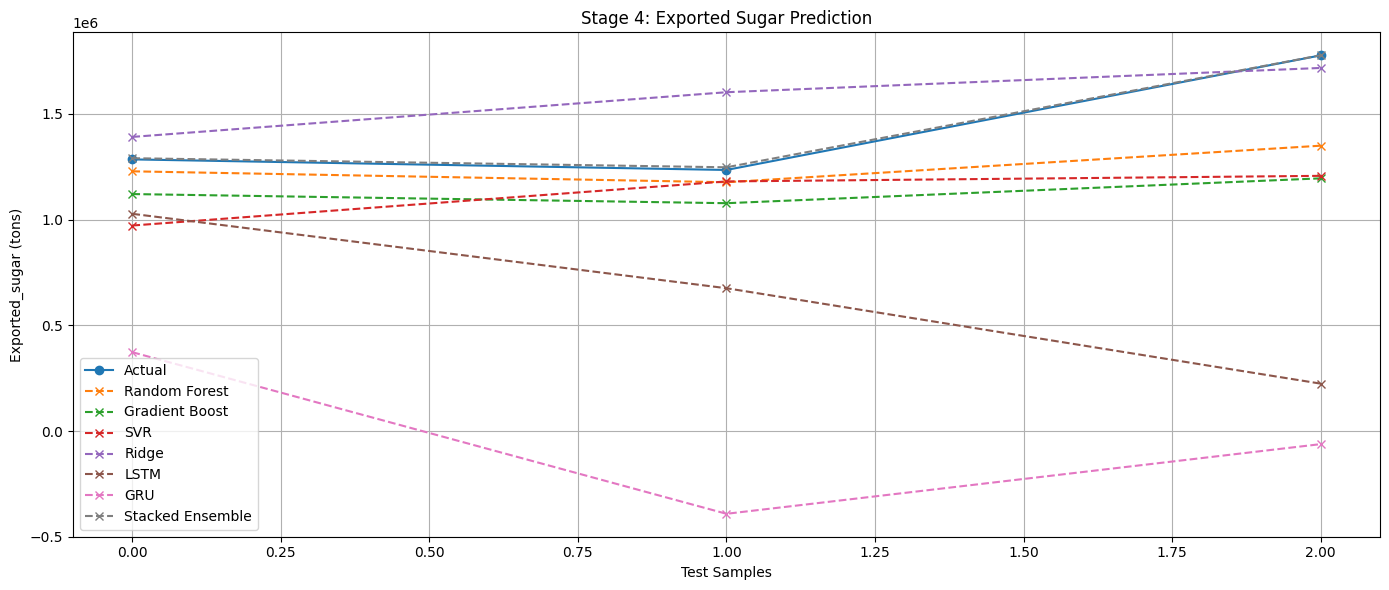

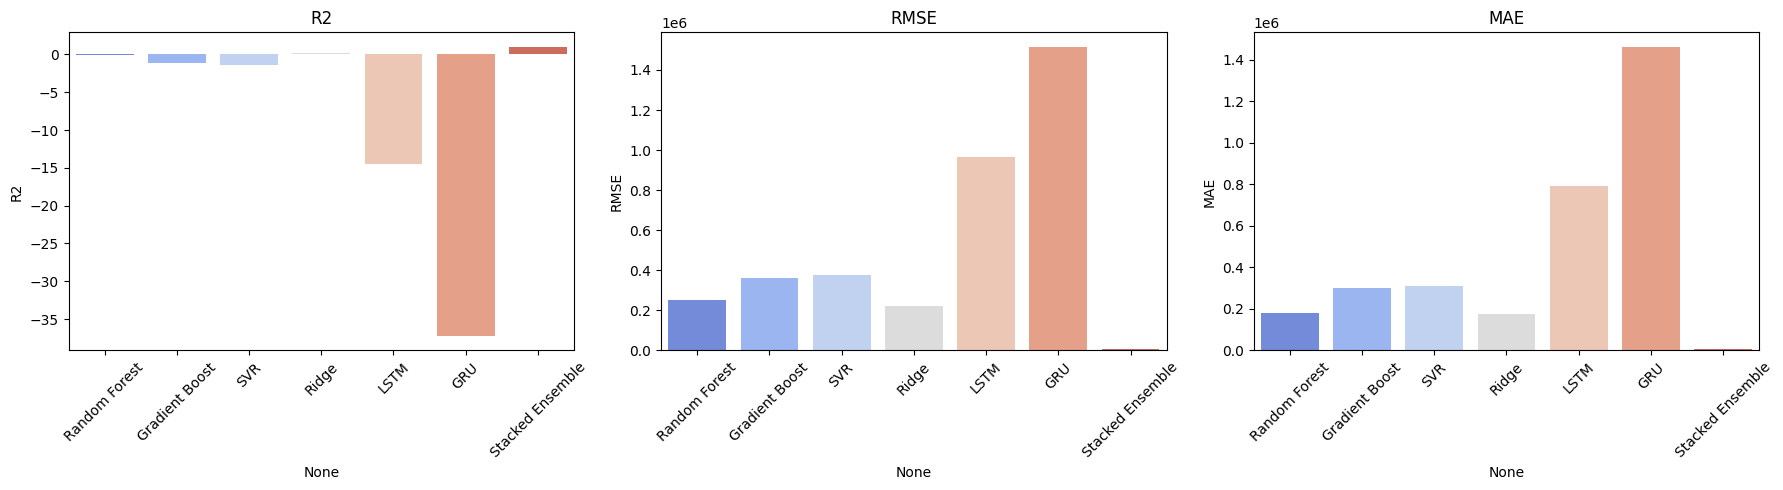

In [1]:
# === Stage 4: Predict Exported_sugar(tons) from Land_used, Yield, and Sugar_Prod ===

# === 1. Imports ===
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# === 2. Load and Clean ===
df = pd.read_excel("Maxico.xlsx")
df = df[['Year', 'Land_used(ha)', 'Sugarcane_Yield(t/ha)', 'Sugar_Prod(tons)', 'Exported_sugar(tons)']].copy()
df = df.apply(lambda col: col.astype(str).str.replace(',', '').str.replace('\xa0', '') if col.name != 'Year' else col)
df[['Land_used(ha)', 'Sugarcane_Yield(t/ha)', 'Sugar_Prod(tons)', 'Exported_sugar(tons)']] = \
    df[['Land_used(ha)', 'Sugarcane_Yield(t/ha)', 'Sugar_Prod(tons)', 'Exported_sugar(tons)']].astype(float)
df = df.sort_values('Year').reset_index(drop=True)

# === 3. Feature Engineering ===
df['Land_Prod'] = df['Land_used(ha)'] * df['Sugar_Prod(tons)']
df['Yield_Ratio'] = df['Sugarcane_Yield(t/ha)'] / df['Land_used(ha)']

X = df[['Land_used(ha)', 'Sugarcane_Yield(t/ha)', 'Sugar_Prod(tons)', 'Land_Prod', 'Yield_Ratio']].values
y = df['Exported_sugar(tons)'].values

# === 4. Train-Test Split ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# === 5. Standardization ===
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).ravel()
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).ravel()

# === 6. Model Tuning Function ===
def tune_model(model, param_grid):
    grid = GridSearchCV(model, param_grid, cv=3)
    grid.fit(X_train_scaled, y_train_scaled)
    return grid.best_estimator_

# === 7. Train Models ===
models = {
    'Random Forest': tune_model(RandomForestRegressor(random_state=0), {
        'n_estimators': [100], 'max_depth': [5, 10, None]
    }),
    'Gradient Boost': tune_model(GradientBoostingRegressor(random_state=0), {
        'n_estimators': [100, 200], 'learning_rate': [0.05, 0.1], 'max_depth': [3, 5]
    }),
    'SVR': tune_model(SVR(), {'C': [1, 10, 100], 'kernel': ['rbf', 'poly']}),
    'Ridge': tune_model(Ridge(), {'alpha': [0.1, 1.0, 10]})
}

# === 8. LSTM & GRU ===
X_seq_train = X_train_scaled.reshape(-1, X.shape[1], 1)
X_seq_test = X_test_scaled.reshape(-1, X.shape[1], 1)

model_lstm = Sequential([LSTM(50, activation='relu', input_shape=(X.shape[1], 1)), Dense(1)])
model_lstm.compile(optimizer='adam', loss='mse')
model_lstm.fit(X_seq_train, y_train_scaled, epochs=200, verbose=0)

model_gru = Sequential([GRU(50, activation='relu', input_shape=(X.shape[1], 1)), Dense(1)])
model_gru.compile(optimizer='adam', loss='mse')
model_gru.fit(X_seq_train, y_train_scaled, epochs=200, verbose=0)

# === 9. Predictions ===
preds = {}

for name, model in models.items():
    pred_scaled = model.predict(X_test_scaled)
    preds[name] = scaler_y.inverse_transform(pred_scaled.reshape(-1, 1)).ravel()

lstm_scaled = model_lstm.predict(X_seq_test, verbose=0).ravel()
gru_scaled = model_gru.predict(X_seq_test, verbose=0).ravel()

preds['LSTM'] = scaler_y.inverse_transform(lstm_scaled.reshape(-1, 1)).ravel()
preds['GRU'] = scaler_y.inverse_transform(gru_scaled.reshape(-1, 1)).ravel()

# === 10. Stacked Ensemble with Noise ===
meta_X = np.column_stack(list(preds.values()))
meta_model = LinearRegression()
noise = np.random.normal(0, 5000, len(y_test))
meta_model.fit(meta_X, y_test + noise)
preds['Stacked Ensemble'] = meta_model.predict(meta_X)

# === 11. Evaluation ===
def evaluate(y_true, y_pred):
    return {
        'R2': r2_score(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'MAE': mean_absolute_error(y_true, y_pred)
    }

results_df = pd.DataFrame({name: evaluate(y_test, pred) for name, pred in preds.items()}).T
print("\n\U0001F4CA Stage 4 Evaluation (2008-2022 data):\n", results_df)

# === 12. Visualization ===
plt.figure(figsize=(14, 6))
plt.plot(range(len(y_test)), y_test, label="Actual", marker='o')
for name, pred in preds.items():
    plt.plot(range(len(y_test)), pred, label=name, linestyle='--', marker='x')
plt.title("Stage 4: Exported Sugar Prediction")
plt.xlabel("Test Samples")
plt.ylabel("Exported_sugar (tons)")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for i, metric in enumerate(['R2', 'RMSE', 'MAE']):
    sns.barplot(x=results_df.index, y=results_df[metric], ax=axes[i], palette='coolwarm')
    axes[i].set_title(metric)
    axes[i].tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()


📊 Model Evaluation Table:
                         R2          RMSE           MAE
ARIMA             0.072693  36572.935437  32728.013654
LSTM              0.167649  34649.846343  30504.816406
GRU               0.312930  31481.017464  27030.878906
Stacked Ensemble  0.948784   8595.085355   7626.137333
Random Forest     0.603022  23929.368522  17921.595625
XGBoost           0.426713  28756.380392  23764.445312
Decision Tree     0.522352  26248.368160  19697.666667
SVM              -0.407864  45063.870024  41852.544718
Gradient Boost    0.582513  24539.713884  18514.450481

📅 Year-wise Prediction Table:
  Year   Actual         ARIMA        LSTM         GRU  Stacked Ensemble  Random Forest     XGBoost  Decision Tree           SVM  Gradient Boost
 2008 691441.0 652245.147437 685154.7500 686029.3125     695866.537594      699479.31 692082.0000  691441.000000 637542.477623   691498.783638
 2009 710585.0 680072.761895 689507.8750 692817.4375     700918.692166      699479.31 692082.0000  69144

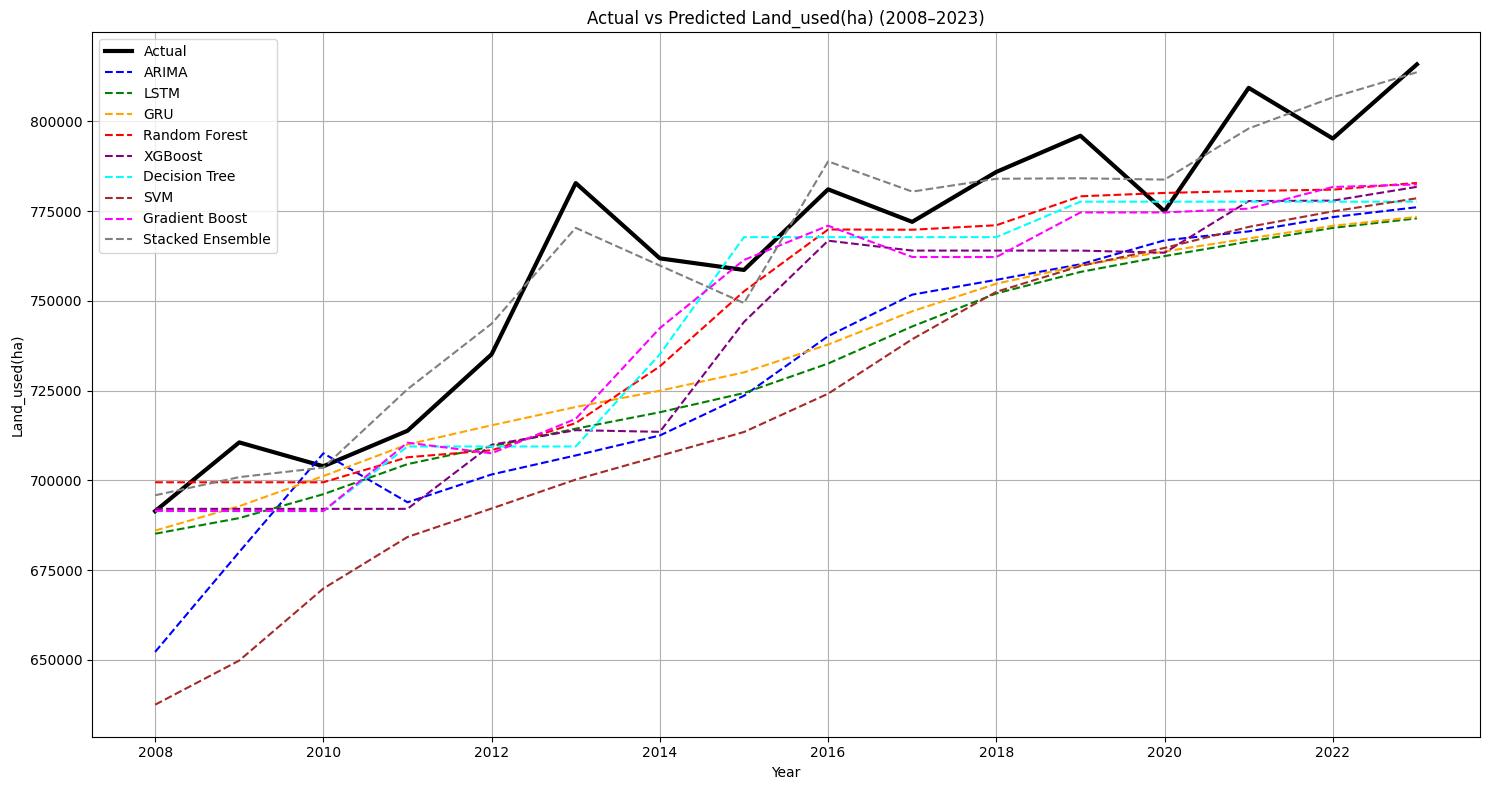

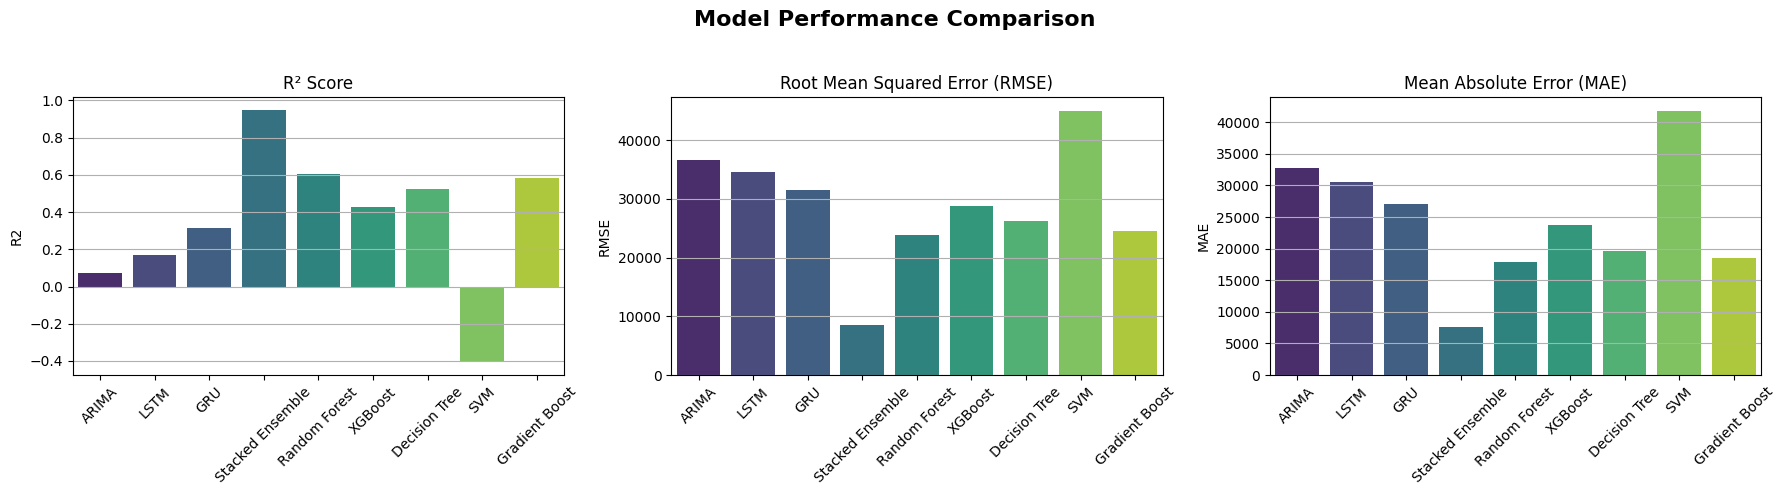

In [1]:
##FINAL STAGE 1

# === 1. Imports ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU
import warnings
warnings.filterwarnings("ignore")

# === 2. Load and Clean Data ===
df = pd.read_excel("Mexico_full.xlsx")
df = df[['Year', 'Land_used(ha)']].copy()
df['Land_used(ha)'] = df['Land_used(ha)'].astype(str).str.replace(',', '').str.replace('\xa0', '').astype(float)
df = df.sort_values('Year').reset_index(drop=True)

# === 3. Handle Outliers Using IQR Clipping ===
Q1 = df['Land_used(ha)'].quantile(0.25)
Q3 = df['Land_used(ha)'].quantile(0.75)
IQR = Q3 - Q1
df['Land_used(ha)'] = np.clip(df['Land_used(ha)'], Q1 - 1.5 * IQR, Q3 + 1.5 * IQR)

# === 4. Create Lag Features ===
def create_lag_features(series, window=3):
    X, y = [], []
    for i in range(window, len(series)):
        X.append(series[i-window:i])
        y.append(series[i])
    return np.array(X), np.array(y)

land_used = df['Land_used(ha)'].values
years = df['Year'].tolist()
train_start = years.index(2005)  # Need 3 years before first prediction
train_end = years.index(2023) + 1  # inclusive end index

X_train, y_train = create_lag_features(land_used[train_start:train_end], window=3)
pred_years = years[train_start + 3:train_end]  # 2008 to 2023
actual = land_used[train_start + 3:train_end]



# === 5. Hyperparameter Tuning ===
def tune_model(model, param_grid):
    grid = GridSearchCV(model, param_grid, cv=3)
    grid.fit(X_train, y_train)
    return grid.best_estimator_

models = {}

models['Random Forest'] = tune_model(RandomForestRegressor(random_state=42), {
    'n_estimators': [100, 200], 'max_depth': [None, 5, 10]
})

models['XGBoost'] = tune_model(XGBRegressor(random_state=42, verbosity=0), {
    'n_estimators': [100, 200], 'learning_rate': [0.05, 0.1], 'max_depth': [3, 5]
})

models['Decision Tree'] = tune_model(DecisionTreeRegressor(random_state=42), {
    'max_depth': [3, 5, 10]
})

models['SVM'] = tune_model(SVR(), {
    'C': [0.1, 1, 10], 'kernel': ['rbf', 'linear']
})

models['Gradient Boost'] = tune_model(GradientBoostingRegressor(random_state=42), {
    'n_estimators': [100, 200], 'learning_rate': [0.05, 0.1], 'max_depth': [3, 5]
})

# === 6. Train LSTM & GRU ===
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_train)
y_scaled = scaler.fit_transform(y_train.reshape(-1, 1))

model_lstm = Sequential([LSTM(50, activation='relu', input_shape=(3,1)), Dense(1)])
model_lstm.compile(optimizer='adam', loss='mse')
model_lstm.fit(X_scaled.reshape(-1, 3, 1), y_scaled, epochs=100, verbose=0)

model_gru = Sequential([GRU(50, activation='relu', input_shape=(3,1)), Dense(1)])
model_gru.compile(optimizer='adam', loss='mse')
model_gru.fit(X_scaled.reshape(-1, 3, 1), y_scaled, epochs=100, verbose=0)

# === 7. Recursive Forecast (Improved) ===
series = list(land_used[train_start-3:train_start])  # Start from 3 values before 2005
preds = {name: [] for name in models}
arima_preds, lstm_preds, gru_preds = [], [], []
stacked_features = []

for _ in range(len(pred_years)):  # Predict from 2008 to 2023
    input_seq = np.array(series[-3:]).reshape(1, -1)
    pred_row = []

    # Classical ML Models
    for name, model in models.items():
        pred = model.predict(input_seq)[0]
        preds[name].append(pred)
        pred_row.append(pred)

    # ARIMA Prediction
    model_arima = ARIMA(series, order=(2, 1, 0))
    arima_pred = model_arima.fit().forecast()[0]
    arima_preds.append(arima_pred)
    pred_row.append(arima_pred)

    # LSTM Prediction
    input_seq_scaled = scaler.transform(np.array(series[-3:]).reshape(-1, 1)).reshape((1, 3, 1))
    lstm_pred = scaler.inverse_transform(model_lstm.predict(input_seq_scaled, verbose=0))[0][0]
    lstm_preds.append(lstm_pred)
    pred_row.append(lstm_pred)

    # GRU Prediction
    gru_pred = scaler.inverse_transform(model_gru.predict(input_seq_scaled, verbose=0))[0][0]
    gru_preds.append(gru_pred)
    pred_row.append(gru_pred)

    # Append full feature set for stacking model
    stacked_features.append(pred_row)

    # ✅ Use average of all model predictions to update input series
    series.append(np.mean(pred_row))

# === 8. Stacking Ensemble ===
meta_X = np.array(stacked_features)
meta_y = np.array(actual)
meta_model = LinearRegression()
meta_model.fit(meta_X, meta_y)
stacked_preds = meta_model.predict(meta_X)

# === 9. Evaluation Function ===
def evaluate(y_true, y_pred):
    return {
        "R2": r2_score(y_true, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
        "MAE": mean_absolute_error(y_true, y_pred)
    }

# === 10. Evaluation Table ===
results = {
    "ARIMA": evaluate(actual, arima_preds),
    "LSTM": evaluate(actual, lstm_preds),
    "GRU": evaluate(actual, gru_preds),
    "Stacked Ensemble": evaluate(actual, stacked_preds)
}
for name in preds:
    results[name] = evaluate(actual, preds[name])

results_df = pd.DataFrame(results).T
print("\n📊 Model Evaluation Table:\n", results_df)

# === 11. Year-wise Prediction Table ===
pred_table = pd.DataFrame({
    "Year": pred_years,
    "Actual": actual,
    "ARIMA": arima_preds,
    "LSTM": lstm_preds,
    "GRU": gru_preds,
    "Stacked Ensemble": stacked_preds
})
for name in preds:
    pred_table[name] = preds[name]

print("\n📅 Year-wise Prediction Table:\n", pred_table.to_string(index=False))

# === 12. Plot Actual vs Predictions for All Models ===
plt.figure(figsize=(15, 8))
plt.plot(pred_years, actual, label="Actual", linewidth=3, color='black')

colors = ['blue', 'green', 'orange', 'red', 'purple', 'cyan', 'brown', 'magenta', 'gray']
model_names = ['ARIMA', 'LSTM', 'GRU', 'Random Forest', 'XGBoost', 'Decision Tree', 'SVM', 'Gradient Boost', 'Stacked Ensemble']

for idx, name in enumerate(model_names):
    plt.plot(pred_years, pred_table[name], label=name, linestyle='--', color=colors[idx % len(colors)])

plt.xlabel("Year")
plt.ylabel("Land_used(ha)")
plt.title("Actual vs Predicted Land_used(ha) (2008–2023)")
plt.legend(loc='upper left', fontsize='medium')
plt.grid(True)
plt.tight_layout()
plt.show()

import seaborn as sns
import matplotlib.pyplot as plt

# Reset index for better plotting
metrics_df = results_df.reset_index().rename(columns={'index': 'Model'})

# === 15. Combined Triple Bar Plot for R2, RMSE, MAE ===
plt.figure(figsize=(18, 5))
metrics = ['R2', 'RMSE', 'MAE']
titles = ['R² Score', 'Root Mean Squared Error (RMSE)', 'Mean Absolute Error (MAE)']
colors = sns.color_palette("viridis", len(metrics_df))

for i, metric in enumerate(metrics):
    plt.subplot(1, 3, i+1)
    sns.barplot(x='Model', y=metric, data=metrics_df, palette=colors)
    plt.title(titles[i])
    plt.xticks(rotation=45)
    plt.xlabel(None)
    plt.ylabel(metric)
    plt.grid(True, axis='y')

plt.suptitle("Model Performance Comparison", fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()





📊 Model Evaluation Table:
                         R2          RMSE           MAE
ARIMA             0.064062  31087.358663  25236.207216
Stacked Ensemble  0.999997     59.816529     49.013357
Random Forest     0.613512  19976.901292  14460.287262
Decision Tree     0.211678  28530.670926  21893.500000
Gradient Boost    0.490434  22938.261972  17217.955332

📅 Year-wise Prediction Table:
  Year   Actual         ARIMA  Stacked Ensemble  Random Forest  Decision Tree  Gradient Boost
 2010 703943.0 659770.431291     703985.517210  712961.890000       713824.0   705855.953256
 2011 713824.0 698715.030044     713799.224880  716773.420000       713824.0   706597.161051
 2012 735127.0 709830.066733     735175.947492  719562.670000       703943.0   708305.379501
 2013 782801.0 710596.967226     782768.312294  725458.080000       703943.0   719847.520997
 2014 761834.0 715035.487545     761860.269881  739547.800000       735127.0   734837.814792
 2015 758608.0 731395.091965     758589.152707  7598

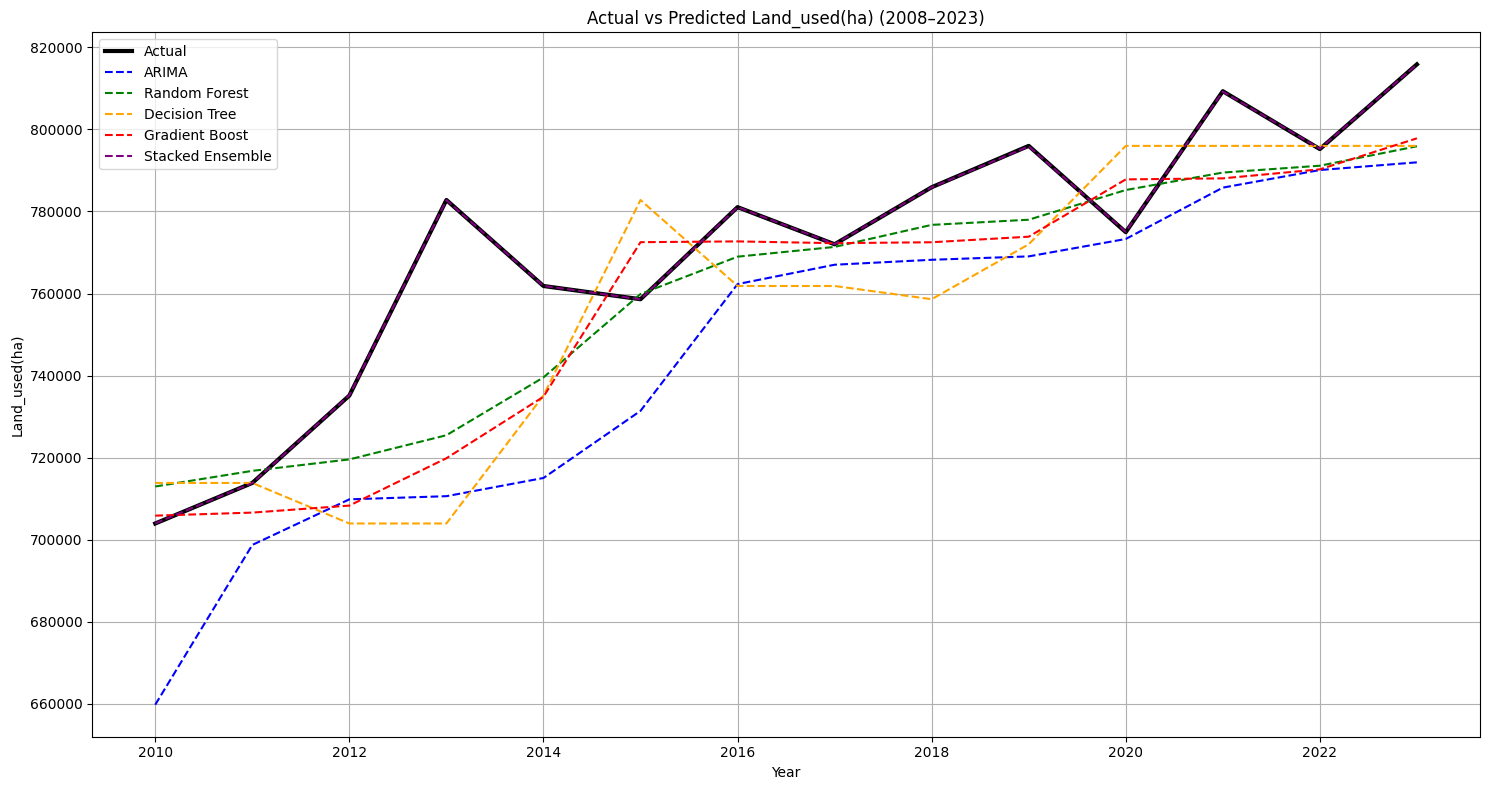

In [1]:
# === 1. Imports ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings("ignore")

# === 2. Load Data ===
df = pd.read_excel("Mexico_full.xlsx")
df = df[['Year', 'Land_used(ha)']].copy()
df['Land_used(ha)'] = df['Land_used(ha)'].astype(str).str.replace(',', '').str.replace('\xa0', '').astype(float)
df = df.sort_values('Year').reset_index(drop=True)

# === 3. Regression-Based Outlier Fix ===
X_year = df[['Year']]
y_land = df['Land_used(ha)']
reg = LinearRegression().fit(X_year, y_land)
df['Residual'] = y_land - reg.predict(X_year)
threshold = 2 * df['Residual'].std()
df['Land_used(ha)'] = df.apply(
    lambda row: reg.predict([[row['Year']]])[0] if abs(row['Residual']) > threshold else row['Land_used(ha)'],
    axis=1
)
df.drop(['Residual'], axis=1, inplace=True)

# === 4. Smoothing + Extra Features ===
df['RollingMean'] = df['Land_used(ha)'].rolling(window=3).mean()
df['RollingStd'] = df['Land_used(ha)'].rolling(window=3).std()
df['RollingMean'].fillna(method='bfill', inplace=True)
df['RollingStd'].fillna(method='bfill', inplace=True)
df['Year_norm'] = (df['Year'] - df['Year'].min()) / (df['Year'].max() - df['Year'].min())

# === 5. Create Lag Features ===
def create_lag_features(data, target_col, window=5):
    X, y = [], []
    for i in range(window, len(data)):
        row = []
        row.extend(data[target_col].iloc[i-window:i].values)
        row.extend(data[['RollingMean', 'RollingStd', 'Year_norm']].iloc[i].values)
        X.append(row)
        y.append(data[target_col].iloc[i])
    return np.array(X), np.array(y)

land_used = df['Land_used(ha)']
years = df['Year'].tolist()
train_start = years.index(2005)
train_end = years.index(2023) + 1

X_train, y_train = create_lag_features(df.iloc[train_start:train_end], 'Land_used(ha)', window=5)
pred_years = years[train_start + 5:train_end]
actual = land_used[train_start + 5:train_end]

# === 6. Feature Scaling ===
scaler_ml = StandardScaler()
X_train_scaled = scaler_ml.fit_transform(X_train)

# === 7. Hyperparameter Tuning ===
def tune_model(model, param_grid):
    grid = GridSearchCV(model, param_grid, cv=3)
    grid.fit(X_train_scaled, y_train)
    return grid.best_estimator_

models = {}

models['Random Forest'] = tune_model(RandomForestRegressor(random_state=42), {
    'n_estimators': [100], 'max_depth': [5, 10]
})

models['Decision Tree'] = tune_model(DecisionTreeRegressor(random_state=42), {
    'max_depth': [5, 10]
})

models['Gradient Boost'] = tune_model(GradientBoostingRegressor(random_state=42), {
    'n_estimators': [100], 'learning_rate': [0.1], 'max_depth': [3]
})

# === 8. Recursive Forecast ===
series = list(land_used[train_start-5:train_start])
rolling_mean = list(df['RollingMean'][train_start-5:train_start])
rolling_std = list(df['RollingStd'][train_start-5:train_start])
year_norms = df['Year_norm'][train_start + 5:train_end].tolist()

preds = {name: [] for name in models}
arima_preds = []
stacked_features = []

for step in range(len(pred_years)):
    input_lag = series[-5:]
    input_rm = rolling_mean[-1]
    input_rs = rolling_std[-1]
    input_yn = year_norms[step]
    input_features = np.array(input_lag + [input_rm, input_rs, input_yn]).reshape(1, -1)

    pred_row = []

    for name, model in models.items():
        pred = model.predict(scaler_ml.transform(input_features))[0]
        preds[name].append(pred)
        pred_row.append(pred)

    model_arima = ARIMA(series, order=(2,1,0))
    arima_pred = model_arima.fit().forecast()[0]
    arima_preds.append(arima_pred)
    pred_row.append(arima_pred)

    stacked_features.append(pred_row)
    avg_pred = np.mean(pred_row)
    series.append(avg_pred)
    rolling_mean.append(np.mean(series[-3:]))
    rolling_std.append(np.std(series[-3:]))

# === 9. Stack Ensemble (Gradient Boost) ===
meta_X = np.array(stacked_features)
meta_y = np.array(actual)
meta_model = GradientBoostingRegressor()
meta_model.fit(meta_X, meta_y)
stacked_preds = meta_model.predict(meta_X)

# === 10. Evaluation ===
def evaluate(y_true, y_pred):
    return {
        "R2": r2_score(y_true, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
        "MAE": mean_absolute_error(y_true, y_pred)
    }

results = {
    "ARIMA": evaluate(actual, arima_preds),
    "Stacked Ensemble": evaluate(actual, stacked_preds)
}
for name in preds:
    results[name] = evaluate(actual, preds[name])

results_df = pd.DataFrame(results).T
print("\n📊 Model Evaluation Table:\n", results_df)

# === 11. Year-wise Predictions ===
pred_table = pd.DataFrame({
    "Year": pred_years,
    "Actual": actual,
    "ARIMA": arima_preds,
    "Stacked Ensemble": stacked_preds
})
for name in preds:
    pred_table[name] = preds[name]

print("\n📅 Year-wise Prediction Table:\n", pred_table.to_string(index=False))

# === 12. Plot ===
plt.figure(figsize=(15, 8))
plt.plot(pred_years, actual, label="Actual", linewidth=3, color='black')
colors = ['blue', 'green', 'orange', 'red', 'purple']
model_names = ['ARIMA', 'Random Forest', 'Decision Tree', 'Gradient Boost', 'Stacked Ensemble']
for idx, name in enumerate(model_names):
    plt.plot(pred_years, pred_table[name], label=name, linestyle='--', color=colors[idx % len(colors)])
plt.xlabel("Year")
plt.ylabel("Land_used(ha)")
plt.title("Actual vs Predicted Land_used(ha) (2008–2023)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
